## Import library

In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

## Import dataset

In [3]:
df = pd.read_csv("data/small_mnist.csv")
df.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Splitting dataset

In [4]:
# cek apakah terdapat data yang mencapai 255
df.iloc[1:].values.max()

255

In [5]:
# -> .values digunakan untuk mengubah dari bentuk dataframe menjadi numpy array. agar dapat diplot oleh matplotlib karena matplotlib
#  hanya menerima berupa array
# -> / 255 digunakan untuk melakukan scaler terhadap data tersebut
X = df.drop(columns="label").values / 255
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1600, 784), (400, 784), (1600,), (400,))

## Visualize random data

In [6]:
import matplotlib.pyplot as plt

In [7]:
X_train.shape

(1600, 784)

In [8]:
y_train.shape

(1600,)

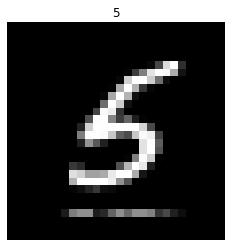

In [9]:
N = len(X_train) # menyimpan banyak data dari X_train kedalam variabel N
idx = np.random.choice(N) # random pick dari data variabel N
img, label = X_train[idx], y_train[idx] # memasukkan hasil dari random pick(idx) X_train ke dalam variabel img, 
                                        # y_train kedalam variabel label

plt.imshow(img.reshape(28,28), cmap='gray') # menampilkan gambar dan mengembalikan bentuk dimensi yang telah diflatten menjadi
                                            # data semua dengan reshape(28,28). cmap(colormap) digunakan untuk merubah color
plt.title(label) # digunakan untuk menampilkan title 
plt.axis('off'); # digunakan untuk menghilangkan angka pada axis x dan axis y
# kenapa menggunakan X_train sebagai img dan y_train sebagai label. itu dikarenakan X_train terdiri dari data dan features 
# sedangkan y_train hanya berisi data saja. oleh karena itu y_train cocok digunakan sebagai title label

## Training

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

In [11]:
rsp.rf_params

{'algo__n_estimators': Integer(low=100, high=200),
 'algo__max_depth': Integer(low=20, high=80),
 'algo__max_features': Real(low=0.1, high=1, prior='uniform'),
 'algo__min_samples_leaf': Integer(low=1, high=20)}

#### tidak menggunakan preprocessor dikarenakan kita telah menggunakan scaling diatas dan tidak perlu mengimpute data apapun sebab data kita tidak terdapat missing value

In [12]:
# preprocessor = ColumnTransformer([
#     ('numeric', num_pipe(), ["______________"]),
#     ('categoric', cat_pipe(encoder='onehot'), ["_____________"]),
# ])

pipeline = Pipeline([
    ('algo', RandomForestClassifier(n_jobs=-1, random_state=42))
])
# apabila data target kita imbalance disarankan menggunakan accuracy dengan jenis f1 score

model = RandomizedSearchCV(pipeline, rsp.rf_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  7.2min finished


{'algo__max_depth': 22, 'algo__max_features': 0.1185260448662222, 'algo__min_samples_leaf': 2, 'algo__n_estimators': 187}
0.999375 0.9025057795953932 0.9275


## Visualize prediction

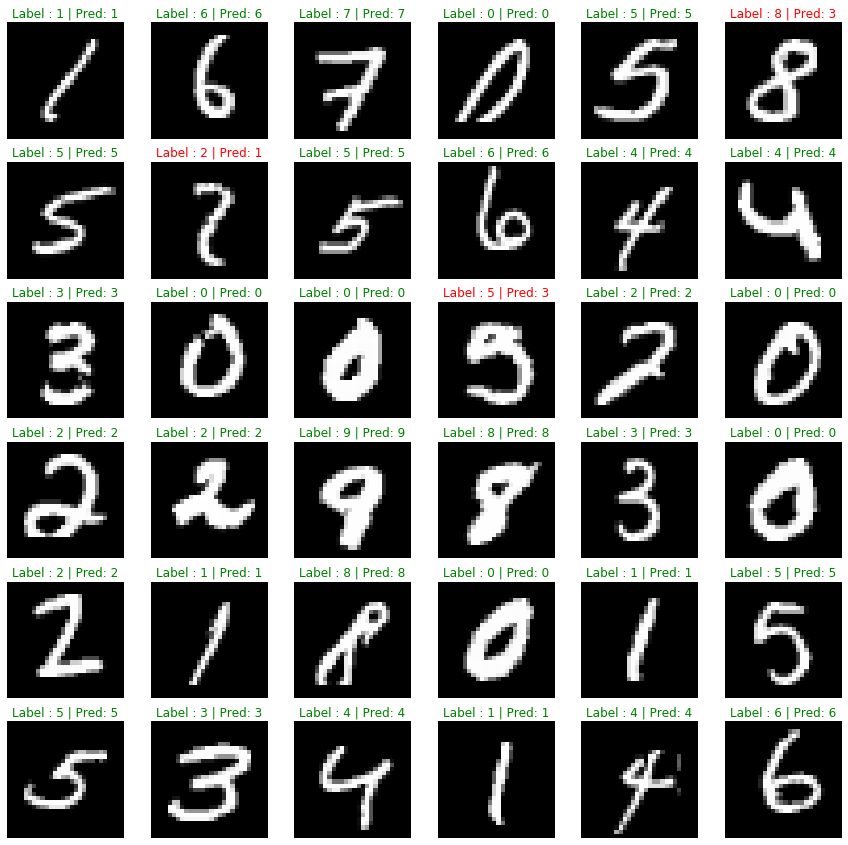

In [20]:
idx = np.random.choice(len(X_test), size=36, replace=False)
images, labels = X_test[idx], y_test[idx]
preds = model.predict(images)

fig, axes = plt.subplots(6, 6, figsize=(15,15))
for img, label, pred, ax in zip(images, labels, preds, axes.flatten()):
    font = {'color': 'g'} if label == pred else {"color":"r"}
    
    ax.imshow(img.reshape(28,28), cmap='gray')
    ax.set_title(f'Label : {label} | Pred: {pred}', fontdict=font)
    ax.axis('off');

## Why it works ?

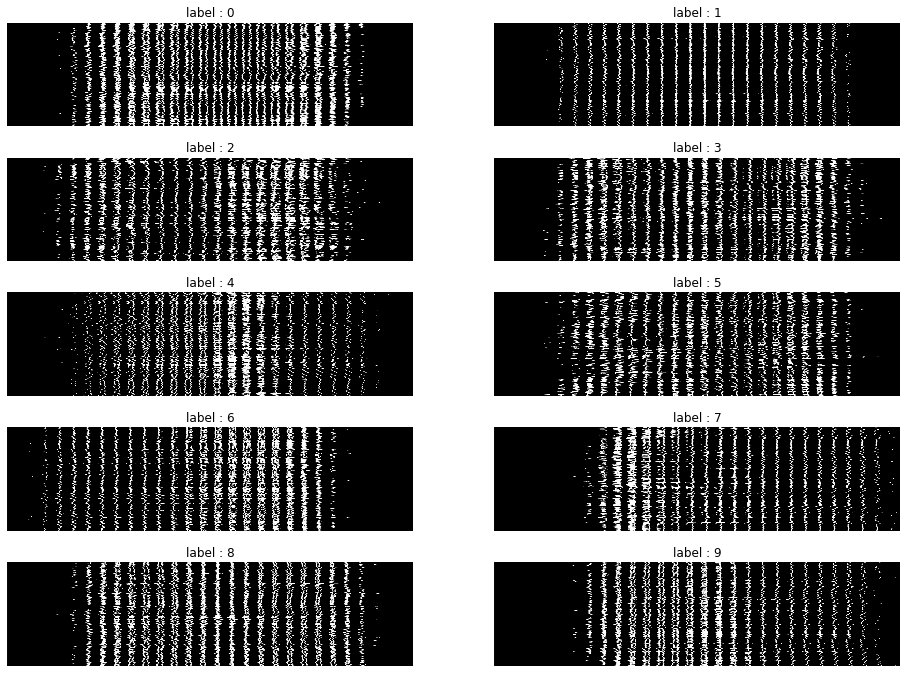

In [21]:
# mesin dapat melihat pattern yang dimiliki setiap angka
fig, axes = plt.subplots(5, 2, figsize=(16,12))

for idx, ax in enumerate(axes.flatten()):
    ax.imshow(df.iloc[idx*200:(idx+1)*200], cmap='gray')
    ax.set_title(f'label : {idx}')
    ax.axis('off')